#### Load libraries

In [6]:
import fastai
from fastai.vision import *

In [7]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split('|')[0])

fastai: 1.0.43.post1
pytorch: 1.0.0
python: 3.6.5 


#### Examine dataset

In [8]:
# download the dataset
path = untar_data(URLs.PLANET_SAMPLE); path

PosixPath('/home/ubuntu/.fastai/data/planet_sample')

In [4]:
# see what files we've got
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/planet_sample/train'),
 PosixPath('/home/ubuntu/.fastai/data/planet_sample/labels.csv'),
 PosixPath('/home/ubuntu/.fastai/data/planet_sample/models')]

In [5]:
# show some sample paths to the images
get_image_files(path/'train')[:5]

[PosixPath('/home/ubuntu/.fastai/data/planet_sample/train/train_36098.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet_sample/train/train_32445.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet_sample/train/train_26272.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet_sample/train/train_19144.jpg'),
 PosixPath('/home/ubuntu/.fastai/data/planet_sample/train/train_30453.jpg')]

torch.Size([3, 256, 256])


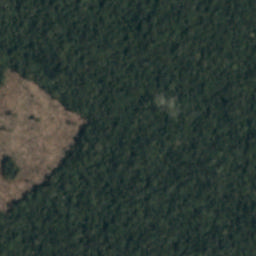

In [6]:
# look the shape and visualize one image
img = open_image(get_image_files(path/'train')[0])
print(img.shape)
img

In [7]:
# load the lables into a dataframe
df = pd.read_csv(path/'labels.csv')
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


In [8]:
# see how much data there is
print(len(os.listdir(path/'train')))
print(len(df))

1000
1000


#### Create datablock

In [9]:
# set hyperparamters
np.random.seed(42)
size = 224
bs = 64
num_workers = 4

In [10]:
# define data augmentation transformations
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [12]:
src = (ImageItemList.from_csv(path, 'labels.csv', folder='train', suffix='.jpg')
       .random_split_by_pct()
       .label_from_df(label_delim=' '))

In [13]:
data = (src.transform(tfms, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

#### Do sanity checks

In [14]:
# verify datasets loaded properly
print(len(data.train_ds))
print(len(data.valid_ds))

800
200


In [15]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

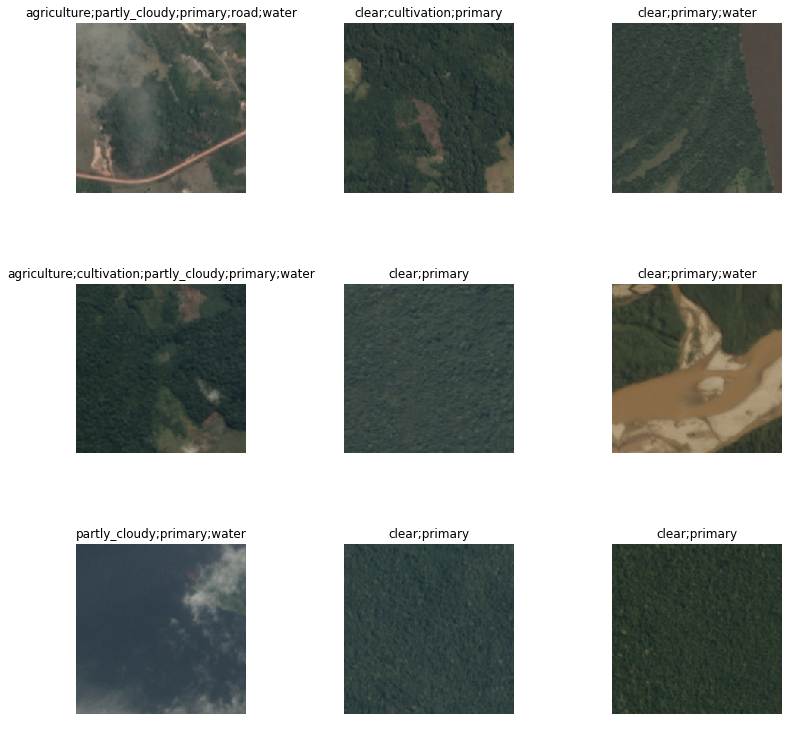

In [16]:
data.show_batch(rows=3, figsize=(11, 11))

#### Create model

In [17]:
# define architecture and metrics
arch = models.resnet50
acc = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [18]:
# create learner
learn = create_cnn(data, arch, metrics=[acc, f_score])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-02


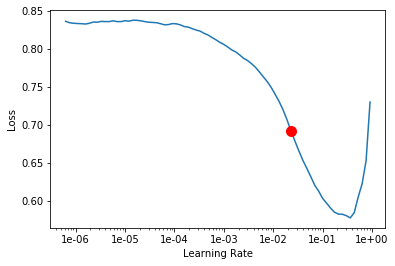

In [19]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [20]:
lr = 2.3e-2

#### Train on frozen model

In [21]:
# first fit the head of the model
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.673962,0.441803,0.489688,0.598166
2,0.414588,0.198957,0.928125,0.855006
3,0.308912,0.144149,0.931562,0.890448
4,0.247860,0.138467,0.938125,0.857024
5,0.206527,0.132942,0.937813,0.862283


In [22]:
learn.save('stage-1')

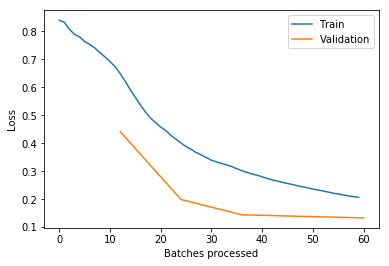

In [23]:
learn.recorder.plot_losses()

#### Train on unfrozen model

In [24]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-06


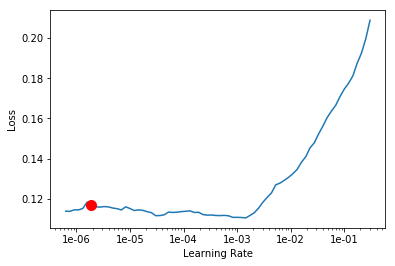

In [25]:
# find ideal learning rate
learn.lr_find()
learn.recorder.plot()

In [26]:
# now fit across the entire model
learn.fit_one_cycle(2, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta
1,0.120402,0.130650,0.939375,0.866171
2,0.115802,0.128992,0.941250,0.876793


In [27]:
learn.save('stage-2')

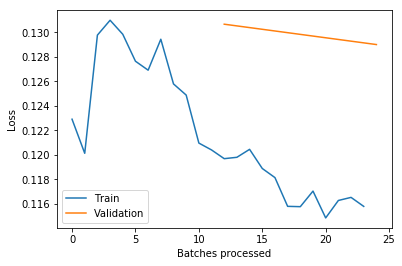

In [28]:
learn.recorder.plot_losses()